In [ ]:
#pip install tensorflow

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# If you're in a notebook environment like Colab
# First upload your kaggle.json file
#from google.colab import files
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


import shutil
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## IMPORTATION DE LA BASE DE DONNEE

In [4]:


# Set the path to the file you'd like to load
file_path = "african_plums_dataset/organized_plums_data_new.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "arnaudfadja/african-plums-quality-and-defect-assessment-data",
  file_path
)

print("First 5 records:", df.head())

C:\Users\Ultra Tech\AppData\Local\Temp\ipykernel_6952\4095643044.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|████████████████████████████████████████████████████████████████████████████████| 150k/150k [00:01<00:00, 126kB/s]

First 5 records:          Image ID      Label Defect Type
0  bruised_plum_1  defective     bruised
1  bruised_plum_2  defective     bruised
2  bruised_plum_3  defective     bruised
3  bruised_plum_4  defective     bruised
4  bruised_plum_5  defective     bruised


## Data description


In [5]:
df.shape

(4507, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image ID     4507 non-null   object
 1   Label        4507 non-null   object
 2   Defect Type  4507 non-null   object
dtypes: object(3)
memory usage: 105.8+ KB


In [7]:
df['Defect Type'].value_counts()

Defect Type
unaffected    1721
unripe         826
spotted        759
rotten         720
bruised        319
cracked        162
Name: count, dtype: int64

In [8]:
df['Label'].value_counts()

Label
defective    1960
good         1721
unripe        826
Name: count, dtype: int64

## configuration api

## importation des images

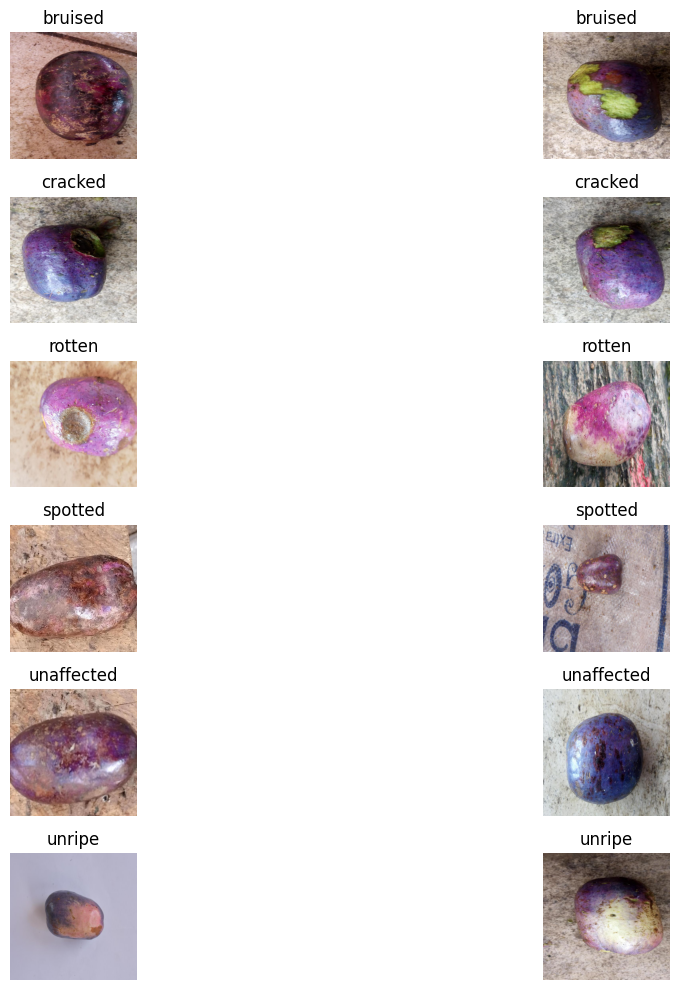

Statistiques du dataset African Plums:
Nombre total d'images: 4507
  - bruised: 319 images (7.1%)
  - cracked: 162 images (3.6%)
  - rotten: 720 images (16.0%)
  - spotted: 759 images (16.8%)
  - unaffected: 1721 images (38.2%)
  - unripe: 826 images (18.3%)


In [13]:
import random
# Chemin vers le dossier principal
base_path = "african_plums/african_plums_dataset/african_plums"

# Liste des sous-dossiers (catégories)
categories = ["bruised", "cracked", "rotten", "spotted", "unaffected", "unripe"]

# Fonction pour obtenir des images aléatoires de chaque catégorie
def get_random_images(num_images=1):
    images = {}

    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.exists(category_path):
            image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                selected_files = random.sample(image_files, min(num_images, len(image_files)))
                images[category] = [os.path.join(category_path, img) for img in selected_files]

    return images

# Fonction pour afficher des images
def display_images(images_dict, figsize=(15, 10)):
    fig, axes = plt.subplots(len(images_dict), len(next(iter(images_dict.values()))), figsize=figsize)

    for i, (category, img_paths) in enumerate(images_dict.items()):
        for j, img_path in enumerate(img_paths):
            img = Image.open(img_path)
            if len(images_dict) > 1:
                ax = axes[i, j] if len(next(iter(images_dict.values()))) > 1 else axes[i]
            else:
                ax = axes[j] if len(next(iter(images_dict.values()))) > 1 else axes

            ax.imshow(np.array(img))
            ax.set_title(f"{category}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Obtenir et afficher 2 images aléatoires de chaque catégorie
random_images = get_random_images(num_images=2)
display_images(random_images)

# Pour afficher des statistiques sur le dataset
def dataset_stats():
    stats = {}
    total_images = 0

    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.exists(category_path):
            image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            stats[category] = len(image_files)
            total_images += len(image_files)

    print(f"Statistiques du dataset African Plums:")
    print(f"Nombre total d'images: {total_images}")
    for category, count in stats.items():
        print(f"  - {category}: {count} images ({count/total_images*100:.1f}%)")

# Afficher les statistiques
dataset_stats()

## EXPLORE IMAGES

In [14]:
def explore_dataset(base_path):
    categories = os.listdir(base_path)
    categories = [c for c in categories if os.path.isdir(os.path.join(base_path, c))]

    class_distribution = {}
    sample_dimensions = {}

    for category in categories:
        category_path = os.path.join(base_path, category)
        images = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_distribution[category] = len(images)

        # Vérifier dimensions d'une image exemple
        if images:
            # Essayer plusieurs images jusqu'à en trouver une qui fonctionne
            for img_file in images:
                try:
                    sample_img_path = os.path.join(category_path, img_file)
                    # Utiliser PIL directement qui est plus tolérant aux différents formats
                    from PIL import Image
                    with Image.open(sample_img_path) as img:
                        sample_dimensions[category] = img.size + (3 if img.mode == 'RGB' else 1,)
                    break  # Sortir de la boucle si une image est chargée avec succès
                except Exception as e:
                    print(f"Impossible de charger {sample_img_path}: {e}")
                    continue

    return categories, class_distribution, sample_dimensions

try:
    base_path = "african_plums/african_plums_dataset/african_plums"
    categories, distribution, dimensions = explore_dataset(base_path)

    print("Catégories trouvées:", categories)
    print("\nDistribution des classes:")
    for cat, count in distribution.items():
        print(f"{cat}: {count} images")

    print("\nDimensions des échantillons:")
    for cat, dim in dimensions.items():
        print(f"{cat}: {dim}")

except Exception as e:
    print(f"Erreur générale: {e}")

Catégories trouvées: ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']

Distribution des classes:
bruised: 319 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
unaffected: 1721 images
unripe: 826 images

Dimensions des échantillons:
bruised: (640, 640, 3)
cracked: (640, 640, 3)
rotten: (640, 640, 3)
spotted: (640, 640, 3)
unaffected: (640, 640, 3)
unripe: (640, 640, 3)


## Partitionnement des donnees

Dataset partitionné avec succès dans: african_plums_processed
Ratios: Train 70%, Validation 15%, Test 15%

Distribution des images:
Catégorie       Train      Validation Test       Total     
-------------------------------------------------------
bruised         223        47         49         319       
cracked         113        24         25         162       
rotten          503        108        109        720       
spotted         531        113        115        759       
unaffected      1204       258        259        1721      
unripe          578        123        125        826       
Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Found 682 images belonging to 6 classes.

Mapping des classes:
{'bruised': 0, 'cracked': 1, 'rotten': 2, 'spotted': 3, 'unaffected': 4, 'unripe': 5}

Caractéristiques du générateur d'entraînement:
Nombre de classes: 6
Nombre de lots (batches): 99
Nombre d'échantillons: 3152
Taille d'image: (224, 224, 3)


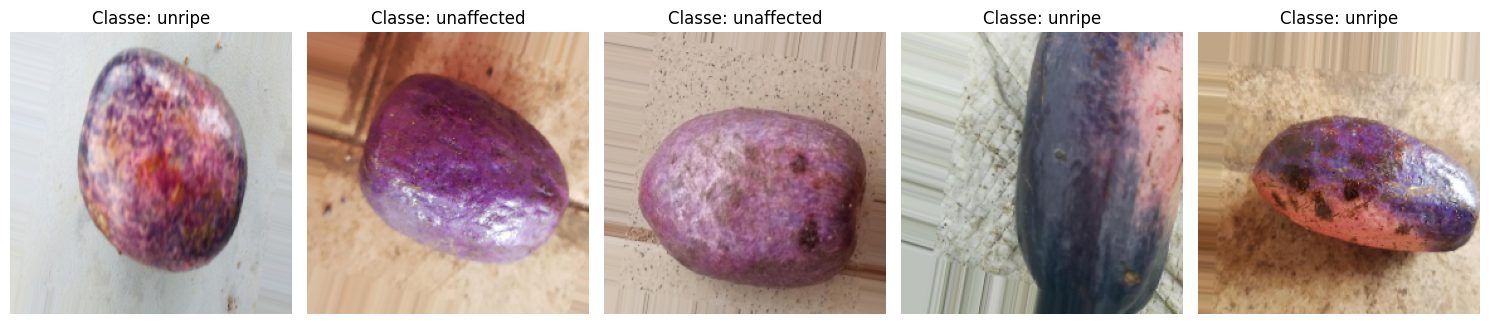

In [15]:
def preprocess_dataset(base_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Prétraitement du dataset d'images:
    1. Partitionnement en train/validation/test
    2. Configuration des générateurs d'images

    Args:
        base_path: Chemin vers le dataset d'origine
        output_path: Chemin où sauvegarder les données partitionnées
        train_ratio: Proportion pour l'ensemble d'entraînement
        val_ratio: Proportion pour l'ensemble de validation
        test_ratio: Proportion pour l'ensemble de test
        seed: Seed pour la reproductibilité

    Returns:
        train_generator, validation_generator, test_generator
    """
    # Vérifier que les proportions sont valides
    assert train_ratio + val_ratio + test_ratio == 1.0, "Les ratios doivent sommer à 1"

    # Créer les dossiers de destination
    train_dir = os.path.join(output_path, 'train')
    val_dir = os.path.join(output_path, 'validation')
    test_dir = os.path.join(output_path, 'test')

    # Nettoyer les dossiers de destination s'ils existent déjà
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)

    # Lister les catégories
    categories = [cat for cat in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, cat))]

    # Créer les sous-dossiers pour chaque catégorie
    for category in categories:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Partitionnement des données
    for category in categories:
        # Chemin vers les images de cette catégorie
        category_path = os.path.join(base_path, category)

        # Récupérer tous les fichiers images
        image_files = [f for f in os.listdir(category_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Mélanger les images
        random.seed(seed)
        random.shuffle(image_files)

        # Calculer les indices de séparation
        n_samples = len(image_files)
        train_end = int(train_ratio * n_samples)
        val_end = train_end + int(val_ratio * n_samples)

        # Séparer les listes d'images
        train_images = image_files[:train_end]
        val_images = image_files[train_end:val_end]
        test_images = image_files[val_end:]

        # Copier les fichiers dans les dossiers respectifs
        for img in train_images:
            shutil.copy2(
                os.path.join(category_path, img),
                os.path.join(train_dir, category, img)
            )

        for img in val_images:
            shutil.copy2(
                os.path.join(category_path, img),
                os.path.join(val_dir, category, img)
            )

        for img in test_images:
            shutil.copy2(
                os.path.join(category_path, img),
                os.path.join(test_dir, category, img)
            )

    # Rapport de partitionnement
    print(f"Dataset partitionné avec succès dans: {output_path}")
    print(f"Ratios: Train {train_ratio:.0%}, Validation {val_ratio:.0%}, Test {test_ratio:.0%}")

    # Compter les images dans chaque partition
    train_counts = {}
    val_counts = {}
    test_counts = {}

    for category in categories:
        train_counts[category] = len(os.listdir(os.path.join(train_dir, category)))
        val_counts[category] = len(os.listdir(os.path.join(val_dir, category)))
        test_counts[category] = len(os.listdir(os.path.join(test_dir, category)))

    print("\nDistribution des images:")
    print(f"{'Catégorie':<15} {'Train':<10} {'Validation':<10} {'Test':<10} {'Total':<10}")
    print("-" * 55)

    for category in categories:
        total = train_counts[category] + val_counts[category] + test_counts[category]
        print(f"{category:<15} {train_counts[category]:<10} {val_counts[category]:<10} {test_counts[category]:<10} {total:<10}")

    # Créer les générateurs d'images
    # Définir la taille cible d'image (ajustez selon vos besoins)
    img_height, img_width = 224, 224
    batch_size = 32

    # Générateur avec augmentation pour l'entraînement
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Générateurs sans augmentation pour validation et test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Créer les générateurs de flux
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Vérifier la correspondance des classes entre les générateurs
    print("\nMapping des classes:")
    print(train_generator.class_indices)

    return train_generator, validation_generator, test_generator

# Exemple d'utilisation
base_path = "african_plums/african_plums_dataset/african_plums"
output_path = "african_plums_processed"

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Prétraiter et partitionner le dataset
train_gen, val_gen, test_gen = preprocess_dataset(base_path, output_path)

# Caractéristiques des générateurs
print("\nCaractéristiques du générateur d'entraînement:")
print(f"Nombre de classes: {len(train_gen.class_indices)}")
print(f"Nombre de lots (batches): {len(train_gen)}")
print(f"Nombre d'échantillons: {train_gen.samples}")
print(f"Taille d'image: {train_gen.image_shape}")

# Visualiser quelques images augmentées (optionnel)
def visualize_augmented_images(generator, num_images=5):
    import matplotlib.pyplot as plt

    # Récupérer un lot d'images
    x_batch, y_batch = next(generator)

    # Afficher quelques images
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(x_batch))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_batch[i])
        class_idx = np.argmax(y_batch[i])
        class_name = list(generator.class_indices.keys())[class_idx]
        plt.title(f"Classe: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualiser quelques images augmentées
visualize_augmented_images(train_gen)

## Definition des models et entrainements

## permiere approche utilisation du  transfert learning  et de la data augmentation (EfficientNetB0) .

## APPROCHE CNN CLASSIQUE

In [22]:
import tensorflow as tf

# 1. Charger le modèle Keras
model = tf.keras.models.load_model('best_finetuned_plum_model.keras')

# 2. Créer un convertisseur TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 3. Configuration du convertisseur (optionnel mais recommandé)
# Optimisation pour la taille
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 4. Effectuer la conversion
tflite_model = converter.convert()

# 5. Sauvegarder le modèle converti
with open('best_finetuned_plum_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ULTRAT~1\AppData\Local\Temp\tmpavaf8uc_\assets


INFO:tensorflow:Assets written to: C:\Users\ULTRAT~1\AppData\Local\Temp\tmpavaf8uc_\assets


Saved artifact at 'C:\Users\ULTRAT~1\AppData\Local\Temp\tmpavaf8uc_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1521150554960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150556112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150556304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150556880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150557072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150557648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150557840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150557264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521150555344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1521131029520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

## Test au travers d une approche Naive

## VGG FINETUNNE

Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Found 682 images belonging to 6 classes.
Nombre de classes: 6
Mapping des classes: {'bruised': 0, 'cracked': 1, 'rotten': 2, 'spotted': 3, 'unaffected': 4, 'unripe': 5}

Modèle initial avec base VGG16 gelée:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,026,438 (68.77 MB)

 Trainable params: 3,311,238 (12.63 MB)

 Non-trainable params: 14,715,200 (56.13 MB)


Phase 1: Entraînement initial avec base VGG16 gelée...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1432 - f1_score: 0.1177 - loss: 2.5027 - precision: 0.1107 - recall: 0.0480
Epoch 1: val_accuracy improved from -inf to 0.20505, saving model to best_initial_plum_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 10s/step - accuracy: 0.1435 - f1_score: 0.1176 - loss: 2.4927 - precision: 0.1119 - recall: 0.0485 - val_accuracy: 0.2051 - val_f1_score: 0.1030 - val_loss: 1.9091 - val_precision: 0.1875 - val_recall: 0.0045 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.

Modèle après dégelage pour fine-tuning:
0 - input_layer_16: False
1 - block1_conv1: False
2 - block1_conv2: False
3 - block1_pool: False
4 - block2_conv1: False
5 - block2_conv2: False
6 - block2_pool: False
7 - block3_conv1: False
8 - block3_conv2: False
9 - block3_conv3: False
10 - block3_pool: False
11 - block4_conv1: False
12 - block4_conv2: False
13 - block4_conv3: False
14 - block

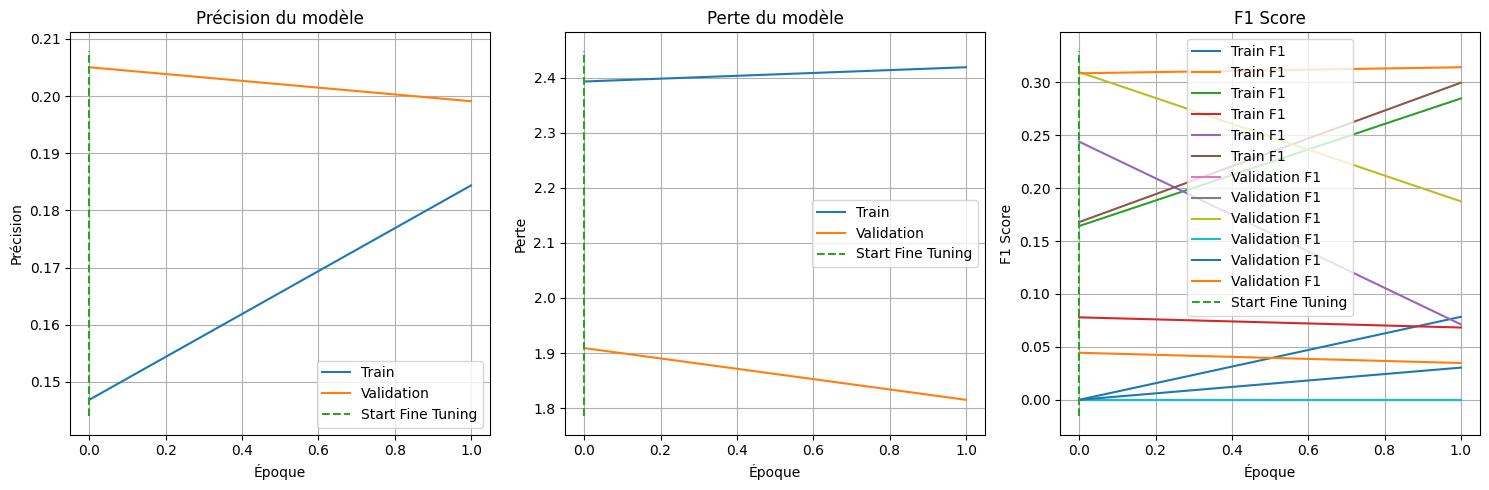


Modèle final avec fine-tuning sauvegardé sous 'final_finetuned_plum_model.keras'


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

step_epoch=10

def create_finetuned_model(input_shape=(160, 160, 3), num_classes=6, fine_tune_at=12):
    """
    Crée un modèle de classification basé sur le transfert learning avec VGG16,
    avec possibilité de fine-tuning.

    Args:
        input_shape: Dimensions des images d'entrée (hauteur, largeur, canaux)
        num_classes: Nombre de classes à prédire
        fine_tune_at: Nombre de couches à geler depuis le début du réseau VGG16
                     (VGG16 a 19 couches au total, donc fine_tune_at=15 débloque
                      les 4 dernières couches pour fine-tuning)

    Returns:
        Un modèle Keras compilé
    """

    # Base du modèle VGG16 pré-entraîné
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Geler les couches initiales et dégeler les dernières couches pour le fine-tuning
    base_model.trainable = True
    
    # Geler toutes les couches d'abord
    for layer in base_model.layers:
        layer.trainable = False
    
    # Dégeler les dernières couches pour le fine-tuning
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True
    
    # Entrée
    inputs = Input(shape=input_shape)

    # Passage dans VGG16
    x = base_model(inputs)

    # Flatten + couches denses personnalisées
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Création du modèle final
    model = Model(inputs, outputs)

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=0.00005),  # Taux d'apprentissage plus faible pour le fine-tuning
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1_score')
        ]
    )

    return model


# Configuration du pipeline d'entraînement avec fine-tuning en deux étapes
def train_finetuned_model(train_dir, val_dir, test_dir, initial_epochs=10, fine_tune_epochs=15):
    """
    Pipeline complet d'entraînement du modèle avec fine-tuning en deux phases:
    1. Entraînement des couches ajoutées avec base gelée
    2. Fine-tuning de quelques couches supérieures du modèle base

    Args:
        train_dir: Chemin vers le répertoire d'entraînement
        val_dir: Chemin vers le répertoire de validation
        test_dir: Chemin vers le répertoire de test
        initial_epochs: Nombre d'époques pour la première phase
        fine_tune_epochs: Nombre d'époques supplémentaires pour le fine-tuning

    Returns:
        Le modèle entraîné et son historique
    """

    # Paramètres
    img_height, img_width = 160, 160
    batch_size = 32

    # Générateurs d'images avec augmentation modérée
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Générateur de validation et test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Créer les générateurs
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Obtenir le nombre de classes
    num_classes = len(train_generator.class_indices)
    print(f"Nombre de classes: {num_classes}")
    print(f"Mapping des classes: {train_generator.class_indices}")

    # --- PHASE 1: Entrainement initial avec base_model gelé ---
    
    # Créer le modèle initial (toutes les couches VGG16 gelées)
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Geler toutes les couches de VGG16
    
    # Construire le modèle complet
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Définir des métriques avec des noms explicites pour assurer la cohérence
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score')
    ]
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    # Résumé du modèle
    print("\nModèle initial avec base VGG16 gelée:")
    model.summary()
    
    # Callbacks pour la première phase
    callbacks_phase1 = [
        ModelCheckpoint(
            'best_initial_plum_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Entraîner le modèle - Phase 1
    print("\nPhase 1: Entraînement initial avec base VGG16 gelée...")
    history_phase1 = model.fit(
        train_generator,
        epochs=initial_epochs,
        steps_per_epoch=step_epoch,  # Limitation à 70 batchs par epoch
        validation_data=validation_generator,
        callbacks=callbacks_phase1,
        verbose=1
    )
    
    # --- PHASE 2: Fine-tuning ---
    
    # Dégeler les dernières couches de VGG16 pour le fine-tuning
    base_model.trainable = True
    fine_tune_at = 15  # Ajuster selon les besoins (entre 10-17 pour VGG16)
    
    # Geler les couches du début de VGG16
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    # Compiler à nouveau avec les MÊMES NOMS DE MÉTRIQUES et un taux d'apprentissage plus faible
    model.compile(
        optimizer=Adam(learning_rate=0.00005),  # Taux d'apprentissage plus faible pour le fine-tuning
        loss='categorical_crossentropy',
        metrics=metrics  # Utilisation des mêmes métriques nommées définies plus haut
    )
    
    # Afficher la structure pour vérifier quelles couches sont entraînables
    print("\nModèle après dégelage pour fine-tuning:")
    # Afficher les couches modifiées
    for i, layer in enumerate(base_model.layers):
        print(f"{i} - {layer.name}: {layer.trainable}")
    
    # Callbacks pour la deuxième phase
    callbacks_phase2 = [
        ModelCheckpoint(
            'best_finetuned_plum_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Continuer l'entraînement avec fine-tuning - Phase 2
    print("\nPhase 2: Fine-tuning des dernières couches de VGG16...")
    total_epochs = initial_epochs + fine_tune_epochs
    
    history_phase2 = model.fit(
        train_generator,
        epochs=total_epochs,
        initial_epoch=initial_epochs,  # Commencer depuis la dernière époque de la phase 1
        steps_per_epoch=step_epoch,
        validation_data=validation_generator,
        callbacks=callbacks_phase2,
        verbose=1
    )
    
    # Combiner les historiques de manière sécurisée pour éviter les erreurs de clés
    history = {}
    
    # Afficher les clés disponibles dans chaque historique pour le débogage
    print("Clés dans history_phase1:", list(history_phase1.history.keys()))
    print("Clés dans history_phase2:", list(history_phase2.history.keys()))
    
    # Combinaison prudente des historiques
    # Métriques communes que nous voulons tracer
    common_metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    
    for metric in common_metrics:
        # Chercher la métrique ou les variantes avec préfixes (val_) ou suffixes (_X)
        for key in history_phase1.history:
            # Métrique principale sans préfixe val_
            if key == metric or key.endswith(f"_{metric}") or (metric in key and not key.startswith("val_")):
                phase1_key = key
                # Chercher la clé correspondante dans phase2
                for key2 in history_phase2.history:
                    if key2 == key or (metric in key2 and key2.replace(metric, "") == key.replace(metric, "")):
                        phase2_key = key2
                        # Combinaison des historiques pour cette métrique
                        combined_key = metric if metric == key else key
                        history[combined_key] = history_phase1.history[phase1_key] + history_phase2.history[phase2_key]
                        break
                        
            # Métrique de validation (avec préfixe val_)
            elif key == f"val_{metric}" or (f"val_{metric}" in key):
                val_phase1_key = key
                # Chercher la clé correspondante dans phase2
                for key2 in history_phase2.history:
                    if key2 == key or (f"val_{metric}" in key2 and key2.replace(f"val_{metric}", "") == key.replace(f"val_{metric}", "")):
                        val_phase2_key = key2
                        # Combinaison des historiques pour cette métrique de validation
                        val_combined_key = f"val_{metric}" if f"val_{metric}" == key else key
                        history[val_combined_key] = history_phase1.history[val_phase1_key] + history_phase2.history[val_phase2_key]
                        break
        
    # --- Évaluation et visualisation ---
    
    # Évaluer le modèle final
    test_results = model.evaluate(test_generator, verbose=1)
    print(f"\nPerformance sur l'ensemble de test après fine-tuning:")
    
    # Afficher les résultats
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    for i, metric_name in enumerate(metric_names):
        if i < len(test_results):
            print(f"{metric_name}: {test_results[i]}")
    
    # Visualiser les courbes d'apprentissage avec indication de la phase de fine-tuning
    plt.figure(figsize=(15, 5))
    
    # Graphique de précision
    plt.subplot(1, 3, 1)
    if 'accuracy' in history:
        plt.plot(history['accuracy'], label='Train')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation')
    plt.plot([initial_epochs-1, initial_epochs-1], 
             plt.ylim(), label='Start Fine Tuning', linestyle='--')
    plt.title('Précision du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)

    # Graphique de perte
    plt.subplot(1, 3, 2)
    if 'loss' in history:
        plt.plot(history['loss'], label='Train')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation')
    plt.plot([initial_epochs-1, initial_epochs-1], 
             plt.ylim(), label='Start Fine Tuning', linestyle='--')
    plt.title('Perte du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True)
    
    # Graphique F1 Score
    plt.subplot(1, 3, 3)
    # Rechercher une clé qui contient 'f1_score' pour le train
    f1_key = next((k for k in history if 'f1_score' in k and not k.startswith('val_')), None)
    val_f1_key = next((k for k in history if 'f1_score' in k and k.startswith('val_')), None)
    
    if f1_key:
        plt.plot(history[f1_key], label='Train F1')
    if val_f1_key:
        plt.plot(history[val_f1_key], label='Validation F1')
    plt.plot([initial_epochs-1, initial_epochs-1], 
             plt.ylim(), label='Start Fine Tuning', linestyle='--')
    plt.title('F1 Score')
    plt.xlabel('Époque')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Sauvegarder le modèle final
    model.save('final_finetuned_plum_model.keras')
    print("\nModèle final avec fine-tuning sauvegardé sous 'final_finetuned_plum_model.keras'")

    return model, history, train_generator, test_generator

# Exécuter le pipeline complet avec fine-tuning
model, history, train_generator, test_generator = train_finetuned_model(
     'african_plums_processed/train',
     'african_plums_processed/validation',
     'african_plums_processed/test',
     initial_epochs=9,
     fine_tune_epochs=16
)

## Model optimiser avec optunna

## optimisatoion de quelques paramettres


Aucun GPU détecté, utilisation du CPU
Erreur lors de la configuration de TensorFlow: Intra op parallelism cannot be modified after initialization.
Démarrage de l'optimisation des hyperparamètres avec Optuna...


[I 2025-04-17 17:40:44,481] A new study created in RDB with name: vgg16_plum_fine_tune_lr_only


Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Essai #0: Nombre de classes: 6
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1433 - f1_score: 0.1254 - loss: 2.8810 - precision: 0.1468 - recall: 0.0759
Epoch 1: val_f1_score improved from -inf to 0.12266, saving model to optuna_models/trial_0_20250417_174045\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 16s/step - accuracy: 0.1439 - f1_score: 0.1254 - loss: 2.8768 - precision: 0.1490 - recall: 0.0775 - val_accuracy: 0.2080 - val_f1_score: 0.1227 - val_loss: 1.7904 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.4647e-06
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1722 - f1_score: 0.1677 - loss: 2.6552 - precision: 0.1466 - recall: 0.0792
Epoch 2: val_f1_score improved from 0.12266 to 0.15049, saving model to optuna_models/trial_0_20250417_174045\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 15s/step - accuracy: 0.1713 - f1_score: 0.1668 -

C:\Users\Ultra Tech\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 10: val_f1_score improved from 0.23831 to 0.24388, saving model to optuna_models/trial_0_20250417_174045\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 14s/step - accuracy: 0.2184 - f1_score: 0.2034 - loss: 2.2243 - precision: 0.2168 - recall: 0.1062 - val_accuracy: 0.2719 - val_f1_score: 0.2439 - val_loss: 1.7702 - val_precision: 1.0000 - val_recall: 0.0030 - learning_rate: 1.0929e-06
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1811 - f1_score: 0.1826 - loss: 2.4383 - precision: 0.1884 - recall: 0.1016
Epoch 11: val_f1_score improved from 0.24388 to 0.24423, saving model to optuna_models/trial_0_20250417_174045\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 15s/step - accuracy: 0.1834 - f1_score: 0.1847 - loss: 2.4377 - precision: 0.1921 - recall: 0.1037 - val_accuracy: 0.2704 - val_f1_score: 0.2442 - val_loss: 1.7650 - val_precision: 1.0000 - val_recall: 0.0030 - learning_rate: 1.0929e-06
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1

[I 2025-04-17 18:27:50,218] Trial 0 finished with value: 0.3248976171016693 and parameters: {'fine_tune_at': 11, 'learning_rate': 5.4646919504051504e-06}. Best is trial 0 with value: 0.3248976171016693.


Résultats sur l'ensemble de test (trial #0):
loss: 1.733963131904602
accuracy: 0.3005865216255188
precision: 0.7142857313156128
recall: 0.0073313782922923565
f1_score: 0.28872016072273254
Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Essai #1: Nombre de classes: 6
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1702 - f1_score: 0.1667 - loss: 2.6007 - precision: 0.1737 - recall: 0.0807
Epoch 1: val_f1_score improved from -inf to 0.05316, saving model to optuna_models/trial_1_20250417_182750\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 11s/step - accuracy: 0.1718 - f1_score: 0.1681 - loss: 2.5891 - precision: 0.1732 - recall: 0.0807 - val_accuracy: 0.1590 - val_f1_score: 0.0532 - val_loss: 2.1159 - val_precision: 0.1842 - val_recall: 0.0104 - learning_rate: 1.4932e-06
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1746 - f1_score: 0.1611 - loss: 2.6702 - precision: 0.2164 - recall: 0.1209
Epoch 2: val_f1_score impro

[I 2025-04-17 19:05:10,571] Trial 1 finished with value: 0.15737637877464294 and parameters: {'fine_tune_at': 18, 'learning_rate': 1.493155665257515e-06}. Best is trial 0 with value: 0.3248976171016693.


Résultats sur l'ensemble de test (trial #1):
loss: 1.8720003366470337
accuracy: 0.18914955854415894
precision: 0.31578946113586426
recall: 0.008797653950750828
f1_score: 0.14788725972175598
Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Essai #2: Nombre de classes: 6
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1420 - f1_score: 0.1572 - loss: 2.4930 - precision: 0.1242 - recall: 0.0550
Epoch 1: val_f1_score improved from -inf to 0.09811, saving model to optuna_models/trial_2_20250417_190511\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 112s 12s/step - accuracy: 0.1436 - f1_score: 0.1587 - loss: 2.4908 - precision: 0.1248 - recall: 0.0557 - val_accuracy: 0.1159 - val_f1_score: 0.0981 - val_loss: 1.8475 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.7587e-06
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1463 - f1_score: 0.1399 - loss: 2.5067 - precision: 0.1287 - recall: 0.0623
Epoch 2: val_f1_s

[I 2025-04-17 19:44:59,812] Trial 2 finished with value: 0.23372678458690643 and parameters: {'fine_tune_at': 18, 'learning_rate': 3.7587388684257205e-06}. Best is trial 0 with value: 0.3248976171016693.


Résultats sur l'ensemble de test (trial #2):
loss: 1.785793423652649
accuracy: 0.2536656856536865
precision: 0.3333333432674408
recall: 0.0014662756584584713
f1_score: 0.27329009771347046
Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Essai #3: Nombre de classes: 6
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1078 - f1_score: 0.0979 - loss: 3.0071 - precision: 0.0982 - recall: 0.0521
Epoch 1: val_f1_score improved from -inf to 0.00236, saving model to optuna_models/trial_3_20250417_194501\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 175s 17s/step - accuracy: 0.1082 - f1_score: 0.0974 - loss: 3.0003 - precision: 0.0990 - recall: 0.0528 - val_accuracy: 0.0342 - val_f1_score: 0.0024 - val_loss: 2.2691 - val_precision: 0.0396 - val_recall: 0.0059 - learning_rate: 1.6381e-05
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1333 - f1_score: 0.1233 - loss: 2.6768 - precision: 0.0903 - recall: 0.0445
Epoch 2: val_f1_score did n

[I 2025-04-17 20:37:12,350] Trial 3 finished with value: 0.47942808270454407 and parameters: {'fine_tune_at': 11, 'learning_rate': 1.638142604464269e-05}. Best is trial 3 with value: 0.47942808270454407.


Résultats sur l'ensemble de test (trial #3):
loss: 1.5224887132644653
accuracy: 0.4838709533214569
precision: 0.7272727489471436
recall: 0.03519061580300331
f1_score: 0.49420809745788574
Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Essai #4: Nombre de classes: 6
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1545 - f1_score: 0.1317 - loss: 2.9975 - precision: 0.1296 - recall: 0.0650
Epoch 1: val_f1_score improved from -inf to 0.05691, saving model to optuna_models/trial_4_20250417_203713\best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - accuracy: 0.1538 - f1_score: 0.1309 - loss: 2.9917 - precision: 0.1323 - recall: 0.0665 - val_accuracy: 0.1828 - val_f1_score: 0.0569 - val_loss: 2.1236 - val_precision: 0.1429 - val_recall: 0.0030 - learning_rate: 2.2949e-05
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1400 - f1_score: 0.1104 - loss: 2.8887 - precision: 0.1168 - recall: 0.0658
Epoch 2: val_f1_score did no

[I 2025-04-17 21:14:45,720] Trial 4 finished with value: 0.4457601308822632 and parameters: {'fine_tune_at': 17, 'learning_rate': 2.2948679100125595e-05}. Best is trial 3 with value: 0.47942808270454407.


Résultats sur l'ensemble de test (trial #4):
loss: 1.5298521518707275
accuracy: 0.4486803412437439
precision: 0.8313252925872803
recall: 0.1011730208992958
f1_score: 0.45766571164131165

Meilleur score (val_f1_score): 0.47942808270454407
Meilleurs hyperparamètres:
  fine_tune_at: 11
  learning_rate: 1.638142604464269e-05


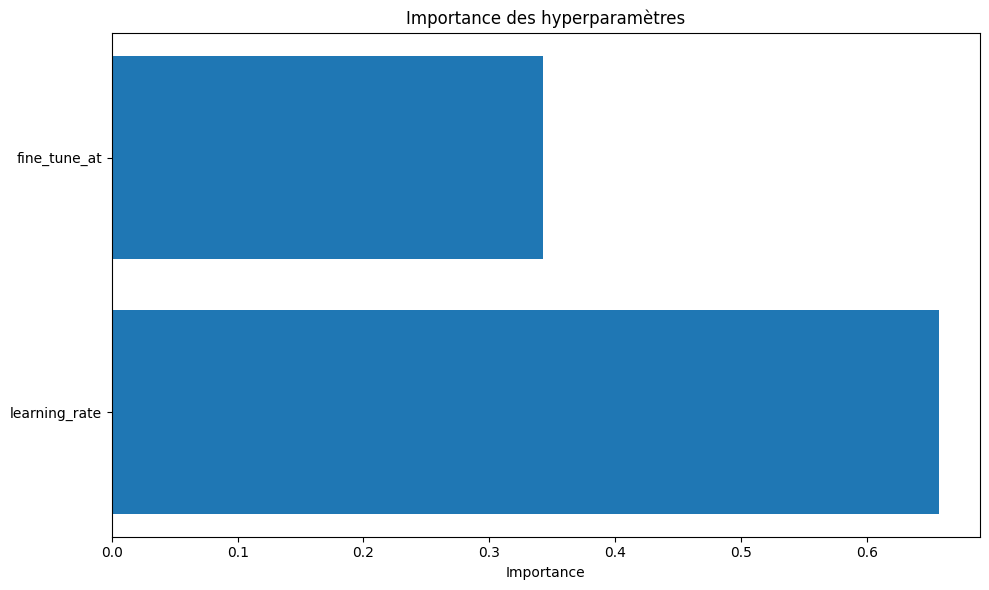

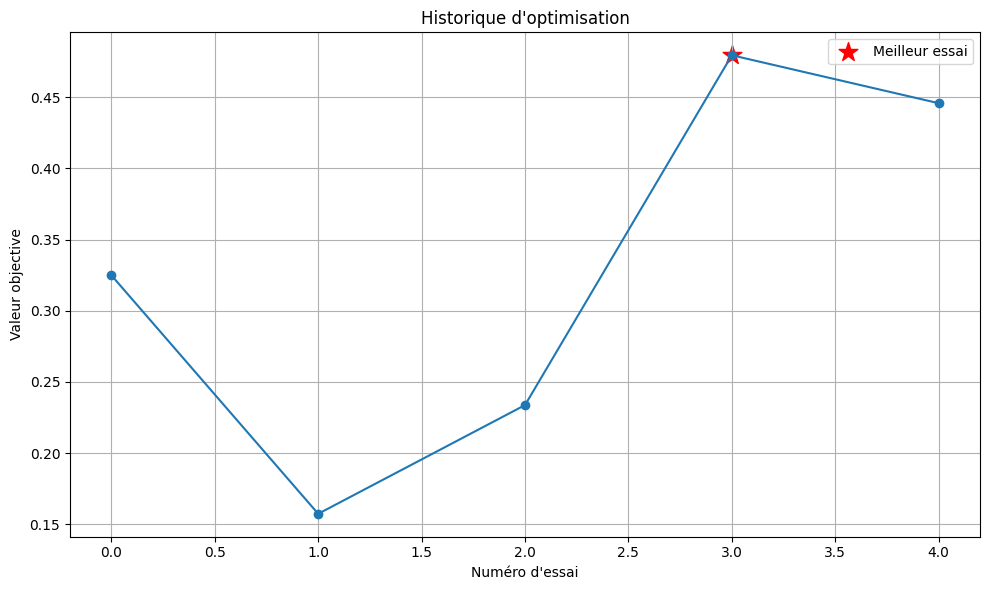

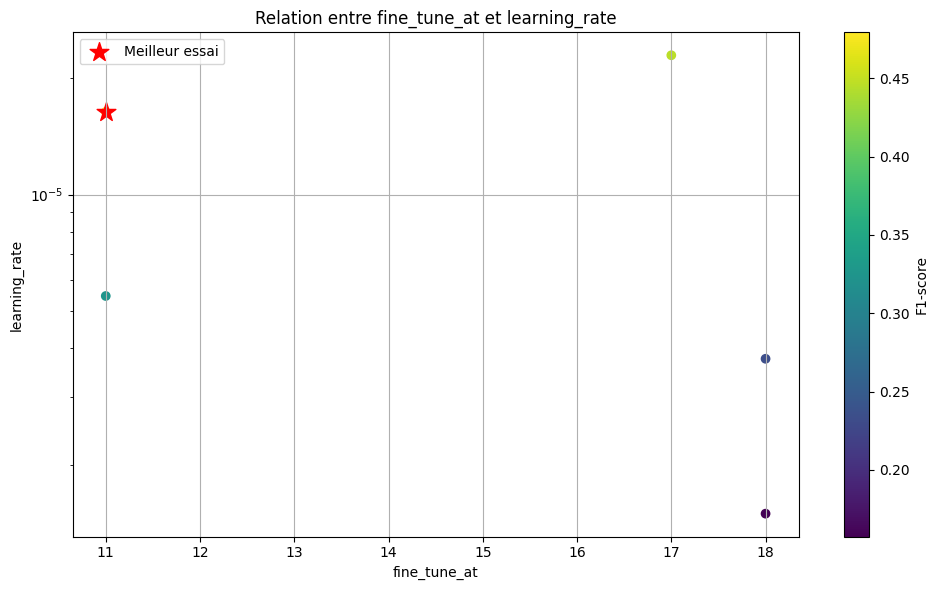


Entraînement du modèle final avec les meilleurs hyperparamètres...
Found 3152 images belonging to 6 classes.
Found 673 images belonging to 6 classes.
Found 682 images belonging to 6 classes.
Nombre de classes: 6
Mapping des classes: {'bruised': 0, 'cracked': 1, 'rotten': 2, 'spotted': 3, 'unaffected': 4, 'unripe': 5}

Modèle initial avec base VGG16 gelée:


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,026,438 (68.77 MB)

 Trainable params: 3,311,238 (12.63 MB)

 Non-trainable params: 14,715,200 (56.13 MB)


Phase 1: Entraînement initial avec base VGG16 gelée...


C:\Users\Ultra Tech\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1726 - f1_score: 0.1765 - loss: 2.6985 - precision: 0.1707 - recall: 0.0854
Epoch 1: val_f1_score improved from -inf to 0.06823, saving model to final_model_20250417_211449\best_initial_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 12s/step - accuracy: 0.1734 - f1_score: 0.1767 - loss: 2.6969 - precision: 0.1740 - recall: 0.0873 - val_accuracy: 0.1590 - val_f1_score: 0.0682 - val_loss: 1.9212 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.2763e-05
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1091 - f1_score: 0.1143 - loss: 2.8403 - precision: 0.1148 - recall: 0.0661
Epoch 2: val_f1_score improved from 0.06823 to 0.06969, saving model to final_model_20250417_211449\best_initial_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 11s/step - accuracy: 0.1117 - f1_score: 0.1173 - loss: 2.8319 - precision: 0.1158 - recall: 0.0666 - val_accuracy: 0.1545 - val_f1_score: 0.0697 - val_loss: 1.9245 - 

C:\Users\Ultra Tech\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 10: val_f1_score improved from 0.14530 to 0.18901, saving model to final_model_20250417_211449\best_initial_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 91s 10s/step - accuracy: 0.2346 - f1_score: 0.2654 - loss: 2.3217 - precision: 0.2703 - recall: 0.1290 - val_accuracy: 0.2229 - val_f1_score: 0.1890 - val_loss: 1.8352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.6381e-05
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2521 - f1_score: 0.2802 - loss: 2.1522 - precision: 0.2795 - recall: 0.1499
Epoch 11: val_f1_score improved from 0.18901 to 0.24525, saving model to final_model_20250417_211449\best_initial_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 111s 12s/step - accuracy: 0.2517 - f1_score: 0.2808 - loss: 2.1589 - precision: 0.2770 - recall: 0.1473 - val_accuracy: 0.2526 - val_f1_score: 0.2452 - val_loss: 1.7984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.6381e-05
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - ac

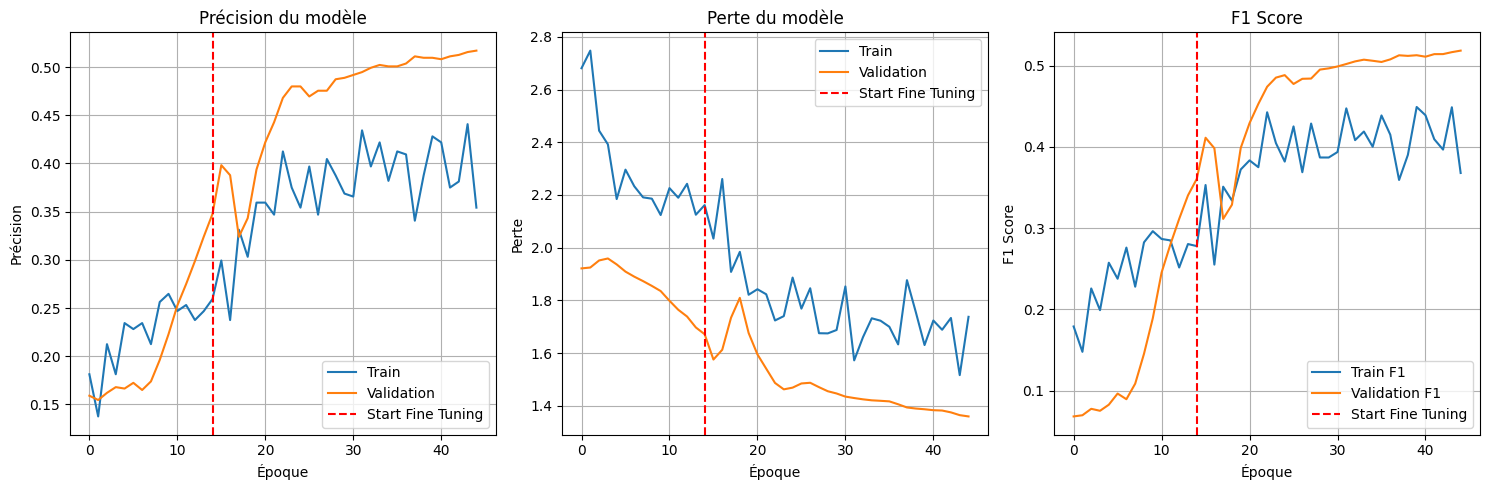

22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.4217 - f1_score: 0.4388 - loss: 1.4865 - precision: 0.5820 - recall: 0.2433

Performance sur l'ensemble de test du modèle final:
loss: 1.3160347938537598
accuracy: 0.5381231904029846
precision: 0.7191780805587769
recall: 0.30791789293289185
f1_score: 0.5297097563743591

Modèle final avec fine-tuning sauvegardé sous 'final_model_20250417_211449\final_model.keras'

Processus d'optimisation et d'entraînement terminé!
Meilleur F1-score sur l'ensemble de test: 0.5297


In [37]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
from datetime import datetime

# Fonction pour créer le modèle avec seulement fine_tune_at et learning_rate optimisés par Optuna
def create_model_with_params(trial, input_shape=(160, 160, 3), num_classes=6):
    """
    Crée un modèle avec uniquement fine_tune_at et learning_rate optimisés par Optuna
    """
    # Hyperparamètres à optimiser (uniquement ces deux)
    fine_tune_at = trial.suggest_int('fine_tune_at', 10, 18)  # Couche à partir de laquelle dégeler VGG16
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)
    
    # Hyperparamètres FIXÉS (non optimisés)
    dropout_rate1 = 0.5  # Valeur fixe
    dropout_rate2 = 0.3  # Valeur fixe
    first_dense_units = 256  # Valeur fixe
    second_dense_units = 128  # Valeur fixe
    
    # Base du modèle VGG16 pré-entraîné
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Geler toutes les couches d'abord
    base_model.trainable = True
    for layer in base_model.layers:
        layer.trainable = False
    
    # Dégeler les dernières couches pour le fine-tuning
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True
    
    # Entrée
    inputs = Input(shape=input_shape)

    # Passage dans VGG16
    x = base_model(inputs)

    # Flatten + couches denses personnalisées (avec valeurs FIXES)
    x = Flatten()(x)
    x = Dense(first_dense_units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate1)(x)
    x = Dense(second_dense_units, activation='relu')(x)
    x = Dropout(dropout_rate2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Création du modèle final
    model = Model(inputs, outputs)

    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1_score', average='weighted')
        ]
    )

    return model

# Fonction objective pour Optuna
def objective(trial, train_dir, val_dir, test_dir, monitor_metric='val_f1_score'):
    """
    Fonction objective pour Optuna qui entraîne et évalue un modèle
    """
    # Paramètres FIXES (non optimisés)
    batch_size = 32  # Valeur fixe
    step_epoch = 10  # Valeur fixe - nombre de batchs par époque
    
    # Paramètres d'entraînement
    img_height, img_width = 160, 160
    
    # Configuration de l'augmentation FIXE (non optimisée)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Générateur de validation et test
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Créer les générateurs avec gestion d'erreur
    try:
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )

        validation_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
    except Exception as e:
        print(f"Erreur lors de la création des générateurs: {e}")
        return float('-inf') if 'maximize' in monitor_metric else float('inf')
    
    # Obtenir le nombre de classes
    num_classes = len(train_generator.class_indices)
    print(f"Essai #{trial.number}: Nombre de classes: {num_classes}")
    
    # Créer le modèle avec les hyperparamètres suggérés
    model = create_model_with_params(trial, input_shape=(img_height, img_width, 3), num_classes=num_classes)
    
    # Déterminer si nous maximisons ou minimisons la métrique
    metric_is_maximize = 'accuracy' in monitor_metric or 'f1' in monitor_metric or 'precision' in monitor_metric or 'recall' in monitor_metric
    mode = 'max' if metric_is_maximize else 'min'
    
    # Callbacks pour l'entraînement
    early_stopping = EarlyStopping(
        monitor=monitor_metric,
        patience=5,
        restore_best_weights=True,
        mode=mode,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Pruning callback pour Optuna - permet d'arrêter les essais non prometteurs
    pruning_callback = optuna.integration.TFKerasPruningCallback(
        trial, monitor_metric)
    
    # Création d'un dossier pour sauvegarder les modèles
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f'optuna_models/trial_{trial.number}_{timestamp}'
    os.makedirs(model_dir, exist_ok=True)
    
    model_checkpoint = ModelCheckpoint(
        os.path.join(model_dir, 'best_model.keras'),
        monitor=monitor_metric,
        save_best_only=True,
        mode=mode,
        verbose=1
    )
    
    # Entraînement du modèle avec gestion d'erreur
    try:
        history = model.fit(
            train_generator,
            epochs=20,  # Maximum d'époques (EarlyStopping décidera quand arrêter)
            steps_per_epoch=step_epoch,
            validation_data=validation_generator,
            callbacks=[early_stopping, reduce_lr, pruning_callback, model_checkpoint],
            verbose=1
        )
    except Exception as e:
        print(f"Erreur pendant l'entraînement pour l'essai #{trial.number}: {e}")
        return float('-inf') if mode == 'max' else float('inf')
    
    # Récupérer le meilleur score
    if monitor_metric in history.history:
        best_value = max(history.history[monitor_metric]) if mode == 'max' else min(history.history[monitor_metric])
    else:
        print(f"Avertissement: la métrique {monitor_metric} n'est pas dans l'historique. Métriques disponibles: {list(history.history.keys())}")
        # Fallback vers une métrique disponible
        if 'val_accuracy' in history.history:
            best_value = max(history.history['val_accuracy'])
        else:
            best_value = float('-inf') if mode == 'max' else float('inf')
    
    # Sauvegarder l'historique et les hyperparamètres pour analyser plus tard
    trial_info = {
        'trial_number': trial.number,
        'hyperparameters': trial.params,
        'best_score': best_value,
        'history': history.history
    }
    
    with open(os.path.join(model_dir, 'trial_info.pkl'), 'wb') as f:
        pickle.dump(trial_info, f)
    
    # Charger le meilleur modèle (celui sauvegardé par ModelCheckpoint)
    try:
        model = tf.keras.models.load_model(os.path.join(model_dir, 'best_model.keras'))
    except Exception as e:
        print(f"Erreur lors du chargement du meilleur modèle: {e}")
        # Si le chargement échoue, utiliser le modèle actuel
        print("Utilisation du modèle actuel pour l'évaluation")
    
    # Évaluer sur l'ensemble de test pour vérifier la généralisation
    try:
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        test_results = model.evaluate(test_generator, verbose=1)
        print(f"Résultats sur l'ensemble de test (trial #{trial.number}):")
        metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
        for i, metric_name in enumerate(metric_names):
            if i < len(test_results):
                print(f"{metric_name}: {test_results[i]}")
        
        # Ajouter les résultats de test à trial_info et sauvegarder
        trial_info['test_results'] = dict(zip(metric_names, test_results))
        with open(os.path.join(model_dir, 'trial_info.pkl'), 'wb') as f:
            pickle.dump(trial_info, f)
    except Exception as e:
        print(f"Erreur lors de l'évaluation sur l'ensemble de test: {e}")
    
    return best_value

# Fonction principale pour exécuter l'optimisation Optuna
def run_optuna_optimization(train_dir, val_dir, test_dir, n_trials=30, study_name='vgg16_transfer_learning', 
                           monitor_metric='val_f1_score', direction='maximize'):
    """
    Lance l'optimisation avec Optuna
    
    Args:
        train_dir: Chemin vers le répertoire d'entraînement
        val_dir: Chemin vers le répertoire de validation
        test_dir: Chemin vers le répertoire de test
        n_trials: Nombre d'essais pour l'optimisation
        study_name: Nom de l'étude Optuna
        monitor_metric: Métrique à optimiser ('val_accuracy', 'val_f1_score', etc.)
        direction: Direction de l'optimisation ('maximize' ou 'minimize')
    
    Returns:
        L'étude Optuna
    """
    # Créer le dossier pour sauvegarder les résultats de l'étude
    os.makedirs('optuna_studies', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    study_file = f'optuna_studies/{study_name}_{timestamp}.db'
    
    # Créer une étude Optuna qui utilise SQLite pour stocker les résultats
    try:
        study = optuna.create_study(
            direction=direction,
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
            study_name=study_name,
            storage=f'sqlite:///{study_file}'
        )
    except Exception as e:
        print(f"Erreur lors de la création de l'étude Optuna: {e}")
        print("Tentative de création d'une étude sans stockage persistant...")
        study = optuna.create_study(
            direction=direction,
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
            study_name=study_name
        )
    
    # Définir la fonction objective partielle avec les chemins des répertoires
    def objective_with_paths(trial):
        return objective(trial, train_dir, val_dir, test_dir, monitor_metric)
    
    # Lancer l'optimisation
    try:
        study.optimize(objective_with_paths, n_trials=n_trials)
    except KeyboardInterrupt:
        print("Optimisation interrompue manuellement.")
    except Exception as e:
        print(f"Erreur pendant l'optimisation: {e}")
    
    # Vérifier si l'étude contient des essais réussis
    if len(study.trials) == 0:
        print("Aucun essai n'a été complété avec succès.")
        return study
    
    # Filtrer les essais avec des valeurs valides
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if len(completed_trials) == 0:
        print("Aucun essai n'a été complété avec succès.")
        return study
    
    # Afficher le meilleur résultat
    print("\n" + "="*50)
    print(f"Meilleur score ({monitor_metric}): {study.best_value}")
    print(f"Meilleurs hyperparamètres:")
    for param, value in study.best_params.items():
        print(f"  {param}: {value}")
    print("="*50)
    
    # Sauvegarder l'étude pour une analyse ultérieure
    try:
        with open(f'optuna_studies/{study_name}_{timestamp}.pkl', 'wb') as f:
            pickle.dump(study, f)
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de l'étude: {e}")
    
    # Tracer les visualisations d'Optuna
    try:
        plot_optuna_results(study, study_name, timestamp)
    except Exception as e:
        print(f"Erreur lors de la création des visualisations Optuna: {e}")
    
    return study

# Fonction pour entraîner le modèle final avec les meilleurs hyperparamètres
def train_final_model(best_params, train_dir, val_dir, test_dir):
    """
    Entraîne le modèle final avec les meilleurs hyperparamètres trouvés
    
    Args:
        best_params: Dictionnaire des meilleurs hyperparamètres trouvés par Optuna
        train_dir: Chemin vers le répertoire d'entraînement
        val_dir: Chemin vers le répertoire de validation
        test_dir: Chemin vers le répertoire de test
    
    Returns:
        Le modèle final entraîné, l'historique d'entraînement et les générateurs
    """
    # Paramètres d'entraînement
    img_height, img_width = 160, 160
    
    # Extraire les paramètres optimisés
    fine_tune_at = best_params['fine_tune_at']
    learning_rate = best_params['learning_rate']
    
    # Paramètres FIXES (non optimisés)
    batch_size = 32
    dropout_rate1 = 0.5
    dropout_rate2 = 0.3
    first_dense_units = 256
    second_dense_units = 128
    step_epoch = 10
    
    # Configuration de l'augmentation FIXE
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Générateur de validation et test
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Créer les générateurs avec gestion d'erreur
    try:
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )

        validation_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
    except Exception as e:
        raise RuntimeError(f"Erreur lors de la création des générateurs: {e}")
    
    # Obtenir le nombre de classes
    num_classes = len(train_generator.class_indices)
    print(f"Nombre de classes: {num_classes}")
    print(f"Mapping des classes: {train_generator.class_indices}")
    
    # --- PHASE 1: Entrainement initial avec base_model gelé ---
    
    # Créer le modèle initial (toutes les couches VGG16 gelées)
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Geler toutes les couches de VGG16
    
    # Construire le modèle complet
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(first_dense_units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate1)(x)
    x = Dense(second_dense_units, activation='relu')(x)
    x = Dropout(dropout_rate2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Définir des métriques avec des noms explicites
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score', average='weighted')
    ]
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=learning_rate * 2),  # Taux d'apprentissage un peu plus élevé pour la phase 1
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    # Résumé du modèle
    print("\nModèle initial avec base VGG16 gelée:")
    model.summary()
    
    # Création d'un dossier pour sauvegarder le modèle final
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f'final_model_{timestamp}'
    os.makedirs(model_dir, exist_ok=True)
    
    # Callbacks pour la première phase
    callbacks_phase1 = [
        ModelCheckpoint(
            os.path.join(model_dir, 'best_initial_model.keras'),
            monitor='val_f1_score',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Entraîner le modèle - Phase 1
    print("\nPhase 1: Entraînement initial avec base VGG16 gelée...")
    initial_epochs = 15  # Plus d'époques pour le modèle final
    
    try:
        history_phase1 = model.fit(
            train_generator,
            epochs=initial_epochs,
            steps_per_epoch=step_epoch,
            validation_data=validation_generator,
            callbacks=callbacks_phase1,
            verbose=1
        )
    except Exception as e:
        raise RuntimeError(f"Erreur pendant la phase 1 d'entraînement: {e}")
    
    # --- PHASE 2: Fine-tuning ---
    
    # Dégeler les dernières couches de VGG16 pour le fine-tuning
    base_model.trainable = True
    
    # Geler les couches du début de VGG16
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    # Compiler à nouveau avec les MÊMES NOMS DE MÉTRIQUES et un taux d'apprentissage plus faible
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Taux d'apprentissage plus faible pour le fine-tuning
        loss='categorical_crossentropy',
        metrics=metrics  # Utilisation des mêmes métriques nommées définies plus haut
    )
    
    # Afficher la structure pour vérifier quelles couches sont entraînables
    print("\nModèle après dégelage pour fine-tuning:")
    # Afficher les couches modifiées
    for i, layer in enumerate(base_model.layers):
        if i == 0 or i == fine_tune_at-1 or i == fine_tune_at or i == len(base_model.layers)-1:
            print(f"{i} - {layer.name}: {layer.trainable}")
    
    # Callbacks pour la deuxième phase
    callbacks_phase2 = [
        ModelCheckpoint(
            os.path.join(model_dir, 'best_finetuned_model.keras'),
            monitor='val_f1_score',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=7,  # Plus de patience pour le modèle final
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=4,  # Plus de patience pour le modèle final
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Continuer l'entraînement avec fine-tuning - Phase 2
    print("\nPhase 2: Fine-tuning des dernières couches de VGG16...")
    fine_tune_epochs = 30  # Plus d'époques pour le modèle final
    total_epochs = initial_epochs + fine_tune_epochs
    
    try:
        history_phase2 = model.fit(
            train_generator,
            epochs=total_epochs,
            initial_epoch=initial_epochs,  # Commencer depuis la dernière époque de la phase 1
            steps_per_epoch=step_epoch,
            validation_data=validation_generator,
            callbacks=callbacks_phase2,
            verbose=1
        )
    except Exception as e:
        raise RuntimeError(f"Erreur pendant la phase 2 d'entraînement: {e}")
    
    # Combiner les historiques de manière simplifiée et robuste
    history = {}
    
    # Afficher les clés disponibles dans chaque historique pour le débogage
    print("Clés dans history_phase1:", list(history_phase1.history.keys()))
    print("Clés dans history_phase2:", list(history_phase2.history.keys()))
    
    # Métriques communes que nous voulons tracer
    metric_prefixes = ['', 'val_']
    base_metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    
    # Approche simplifiée pour combiner les historiques
    for prefix in metric_prefixes:
        for metric in base_metrics:
            full_metric = f"{prefix}{metric}"
            
            # Vérifier si la métrique existe dans les deux historiques
            if full_metric in history_phase1.history and full_metric in history_phase2.history:
                history[full_metric] = history_phase1.history[full_metric] + history_phase2.history[full_metric]
    
    # Visualiser les courbes d'apprentissage avec indication de la phase de fine-tuning
    plt.figure(figsize=(15, 5))
    
    # Graphique de précision
    plt.subplot(1, 3, 1)
    if 'accuracy' in history:
        plt.plot(history['accuracy'], label='Train')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation')
    plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
    plt.title('Précision du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    plt.grid(True)

    # Graphique de perte
    plt.subplot(1, 3, 2)
    if 'loss' in history:
        plt.plot(history['loss'], label='Train')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation')
    plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
    plt.title('Perte du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True)
    
    # Graphique F1 Score
    plt.subplot(1, 3, 3)
    if 'f1_score' in history:
        plt.plot(history['f1_score'], label='Train F1')
    if 'val_f1_score' in history:
        plt.plot(history['val_f1_score'], label='Validation F1')
    plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
    plt.title('F1 Score')
    plt.xlabel('Époque')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'training_curves.png'))
    plt.show()

    # Évaluer sur l'ensemble de test pour vérifier la généralisation
    try:
        test_results = model.evaluate(test_generator, verbose=1)
        print(f"\nPerformance sur l'ensemble de test du modèle final:")
        metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
        for i, metric_name in enumerate(metric_names):
            if i < len(test_results):
                print(f"{metric_name}: {test_results[i]}")
    except Exception as e:
        print(f"Erreur lors de l'évaluation du modèle final: {e}")
        test_results = [0, 0, 0, 0, 0]  # Valeurs par défaut en cas d'erreur
    
    # Sauvegarder le modèle final
    try:
        model.save(os.path.join(model_dir, 'final_model.keras'))
        print(f"\nModèle final avec fine-tuning sauvegardé sous '{os.path.join(model_dir, 'final_model.keras')}'")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde du modèle final: {e}")
        try:
            # Tenter de sauvegarder avec un format alternatif
            model.save(os.path.join(model_dir, 'final_model_h5.h5'), save_format='h5')
            print(f"Modèle sauvegardé au format alternatif H5")
        except Exception as e2:
            print(f"Impossible de sauvegarder le modèle: {e2}")

    # Sauvegarder l'historique et les résultats
    final_info = {
        'best_params': best_params,
        'history': history,
        'test_results': dict(zip(['loss', 'accuracy', 'precision', 'recall', 'f1_score'], test_results)),
        'class_indices': train_generator.class_indices
    }
    
    try:
        with open(os.path.join(model_dir, 'final_model_info.pkl'), 'wb') as f:
            pickle.dump(final_info, f)
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des informations du modèle: {e}")
    
    return model, history, train_generator, test_generator, final_info

def plot_optuna_results(study, study_name, timestamp=None):
    """
    Trace les visualisations Optuna pour l'étude
    
    Args:
        study: Étude Optuna
        study_name: Nom de l'étude
        timestamp: Horodatage pour les noms de fichiers
    """
    if len(study.trials) == 0:
        print("Aucun essai à visualiser.")
        return
        
    timestamp = timestamp or datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs('optuna_plots', exist_ok=True)
    
    # Histogramme des valeurs d'importance des paramètres
    try:
        # Vérifier qu'il y a au moins 2 essais complétés pour calculer l'importance
        completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        if len(completed_trials) >= 2:
            param_importances = optuna.importance.get_param_importances(study)
            plt.figure(figsize=(10, 6))
            importance_df = pd.DataFrame(
                list(param_importances.items()), 
                columns=['Parameter', 'Importance']
            ).sort_values('Importance', ascending=False)
            
            plt.barh(importance_df['Parameter'], importance_df['Importance'])
            plt.xlabel('Importance')
            plt.title('Importance des hyperparamètres')
            plt.tight_layout()
            plt.savefig(f'optuna_plots/{study_name}_param_importance_{timestamp}.png')
            plt.show()
        else:
            print("Pas assez d'essais complétés pour calculer l'importance des paramètres")
    except Exception as e:
        print(f"Erreur lors de la création du graphique d'importance des paramètres: {e}")
    
    # Historique d'optimisation
    try:
        valid_trials = [(t.number, t.value) for t in study.trials if t.value is not None]
        if len(valid_trials) > 0:
            trial_numbers, values = zip(*valid_trials)
            
            plt.figure(figsize=(10, 6))
            plt.plot(trial_numbers, values, 'o-')
            plt.xlabel('Numéro d\'essai')
            plt.ylabel('Valeur objective')
            plt.title('Historique d\'optimisation')
            
            if study.best_trial.value is not None:
                plt.scatter([study.best_trial.number], [study.best_trial.value], 
                            marker='*', color='r', s=200, label='Meilleur essai')
                plt.legend()
                
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'optuna_plots/{study_name}_optimization_history_{timestamp}.png')
            plt.show()
        else:
            print("Aucun essai valide à tracer dans l'historique d'optimisation")
    except Exception as e:
        print(f"Erreur lors de la création du graphique d'historique d'optimisation: {e}")
    
    # Tracer la relation entre fine_tune_at et learning_rate
    try:
        plt.figure(figsize=(10, 6))
        
        fine_tune_at_values = []
        learning_rate_values = []
        obj_values = []
        
        for trial in study.trials:
            if (trial.value is not None and 
                'fine_tune_at' in trial.params and 
                'learning_rate' in trial.params):
                fine_tune_at_values.append(trial.params['fine_tune_at'])
                learning_rate_values.append(trial.params['learning_rate'])
                obj_values.append(trial.value)
        
        if len(fine_tune_at_values) > 0:
            plt.scatter(fine_tune_at_values, learning_rate_values, c=obj_values, cmap='viridis')
            plt.colorbar(label='F1-score')
            plt.xlabel('fine_tune_at')
            plt.ylabel('learning_rate')
            plt.yscale('log')  # Échelle logarithmique pour le learning rate
            plt.title('Relation entre fine_tune_at et learning_rate')
            
            # Marquer le meilleur essai
            if (study.best_trial.value is not None and 
                'fine_tune_at' in study.best_trial.params and 
                'learning_rate' in study.best_trial.params):
                plt.scatter([study.best_trial.params['fine_tune_at']], [study.best_trial.params['learning_rate']], 
                            marker='*', color='r', s=200, label='Meilleur essai')
                plt.legend()
                
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'optuna_plots/{study_name}_fine_tune_at_vs_learning_rate_{timestamp}.png')
            plt.show()
    except Exception as e:
        print(f"Erreur lors de la création du graphique de relation: {e}")

# Fonction principale pour exécuter tout le pipeline
def main():
    """
    Fonction principale qui exécute tout le pipeline d'optimisation et d'entraînement
    """
    # Définir les chemins des répertoires
    train_dir = 'african_plums_processed/train'
    val_dir = 'african_plums_processed/validation'
    test_dir = 'african_plums_processed/test'
    
    # Vérifier que les répertoires existent
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            raise FileNotFoundError(f"Le répertoire {directory} n'existe pas. Assurez-vous que les chemins sont corrects.")
    
    # 1. Exécuter l'optimisation avec Optuna
    print("Démarrage de l'optimisation des hyperparamètres avec Optuna...")
    try:
        study = run_optuna_optimization(
            train_dir=train_dir,
            val_dir=val_dir,
            test_dir=test_dir,
            n_trials=5,  # Réduit à 20 essais car nous n'optimisons que 2 paramètres
            study_name='vgg16_plum_fine_tune_lr_only',
            monitor_metric='val_f1_score',
            direction='maximize'
        )
    except Exception as e:
        print(f"Erreur critique pendant l'optimisation: {e}")
        return
    
    # Vérifier que l'étude a réussi et contient des essais valides
    if len(study.trials) == 0 or not hasattr(study, 'best_params'):
        print("L'optimisation n'a pas produit de résultats utilisables.")
        return
    
    # 2. Entraîner le modèle final avec les meilleurs hyperparamètres
    print("\nEntraînement du modèle final avec les meilleurs hyperparamètres...")
    try:
        model, history, train_generator, test_generator, final_info = train_final_model(
            best_params=study.best_params,
            train_dir=train_dir,
            val_dir=val_dir,
            test_dir=test_dir
        )
        
        print("\nProcessus d'optimisation et d'entraînement terminé!")
        if 'f1_score' in final_info['test_results']:
            print(f"Meilleur F1-score sur l'ensemble de test: {final_info['test_results']['f1_score']:.4f}")
    except Exception as e:
        print(f"Erreur pendant l'entraînement du modèle final: {e}")

# Configuration TensorFlow pour optimiser les performances
def configure_tensorflow():
    """
    Configure TensorFlow pour de meilleures performances
    """
    try:
        # Limiter la croissance de la mémoire GPU
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU(s) disponible(s): {len(gpus)}")
            
            # Optimisations supplémentaires
            tf.config.optimizer.set_jit(True)  # XLA JIT compilation
        else:
            print("Aucun GPU détecté, utilisation du CPU")
            
        # Optimisations supplémentaires
        tf.config.threading.set_intra_op_parallelism_threads(0)  # Utiliser tous les cœurs disponibles
        tf.config.threading.set_inter_op_parallelism_threads(0)
        
    except Exception as e:
        print(f"Erreur lors de la configuration de TensorFlow: {e}")

# Point d'entrée principal
configure_tensorflow()

try:
    main()
except KeyboardInterrupt:
    print("\nExécution interrompue par l'utilisateur.")
except Exception as e:
    print(f"\nEdrreur critique lors de l'exécution: {e}")